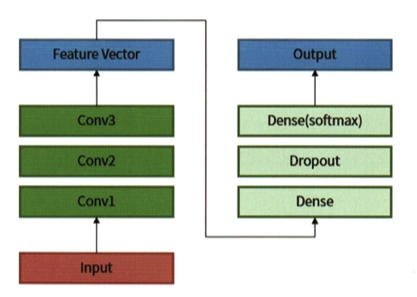

In [ ]:
from IPython.display import  Image
Image('/content/drive/MyDrive/edu.kenshi/2021/품질재단/DL/new_res/전이학습-4.png')
# 전이학습(특성값) + 신규 네트워크 연결

# 기본 모듈

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np

In [ ]:
# 훈련 데이터의 실제 정딥
tf.keras.utils.get_file('/content/labels.csv', 'http://bit.ly/2GDxsYS')
# 경쟁시 제출하는 답안 양식
tf.keras.utils.get_file('/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
# 훈련 데이터 
tf.keras.utils.get_file('/content/train.zip', 'http://bit.ly/31nIyel')
# 테스트 데이터
tf.keras.utils.get_file('/content/test.zip', 'http://bit.ly/2GHEsnO')

'/content/test.zip'

In [ ]:
!unzip train.zip
!unzip test.zip

Archive:  train.zip
replace train/000bec180eb18c7604dcecc8fe0dba07.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.zip
replace test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# 정답 데이터 로드

In [ ]:
import pandas as pd
label_text = pd.read_csv('/content/labels.csv')

# 모델 획득 - Inception v3

- hub를 통해서 Inception V3 모델을 로드
  - 구글에서 이미지 인식 대회에 참가했던 모델
- 입력
  - (?, 299, 299, 3)
- 출력
  - (2048, )
- 파라미터
  - 파라미터 훈련(갱신) 불가

In [ ]:
import tensorflow_hub as hub

feature_model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", 
                output_shape=[2048],
                trainable=False),  # Can be True, see below.
  #tf.keras.layers.Dense(num_classes, activation='softmax')
])

# inception_v3 모델이 입력 데이터로 (?, 299, 299, 3) 입력받는다
feature_model.build([None, 299, 299, 3])  # Batch input shape.

In [ ]:
'''
- Total params: 21,802,784
- Trainable params: 0
- Non-trainable params: 21,802,784
'''
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


# 데이터 공급

- 1회 학습시 필요한 양만 로드 
- tf.data 모델에 데이터를 적용하여 제공
- 데이터가 이미지인경우
  - ImageDataGenerator를 활용
  - 필요할때마다 필요한 만큼 디스크에서 읽어서 제공
  - 이미지 부풀리기
    - 데이터가 적다
    - 픽셀, 반전(상하/좌우), 기울기, 줌, 평행이동(상하/좌우) 등등 작용을 통해서 데이터를 생산해 내는 방법

## ImageDataGenerator

In [ ]:
# 하위 디렉토리를 구성하고, 데이터들을 복사
import os
import shutil

In [ ]:
# 디렉토리 생성
try:
  os.mkdir('/content/train_sub')
except Exception as e:
  pass

In [ ]:
label_text.head(2)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo


In [ ]:
# ImageDataGenerator가 잘 작동될려면
# 해당 정답 폴더
# /content/train_sub/boston_bull/*.jpg
# 이런식으로 120(정답의개수)개의 폴더가 만들어지고, 이름은 breed이름으로 생성, 그 하위에 파일 카피

# 정답의 개수만큼 반복
for i in range( len(label_text) ):
  # 모든 정답을 돌면서, 해당 폴더가 없다면 생성하라
  label_dir = '/content/train_sub/' + label_text.loc[i]['breed']
  if not os.path.exists( label_dir  ):# 없다면
    # 해당 폴더를 만드시오
    os.mkdir( label_dir )

  # 해당 위치에 파일 카피
  fName = label_text.loc[i]['id']
  shutil.copy( f'/content/train/{ fName }.jpg', label_dir )
  #break

- 훈련 데이터로 사용되는 이미지를 보강(부플리기)(Image Augmentation)을 적용
  - 네트워크의 성능을 높인다 -> 정확도 향상

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 이미지 사이즈 (Inception_V3 모델 기초)
image_size = 299
# 배치 사이즈 (설정)
batch_size = 32

- rescale : 픽셀 정규화 처리
- horizontal_flip : 좌우 반전
- shear_range : 기울기
- zoom_range : 줌
- width_shift_range : 좌우 평행이동
- height_shift_range : 상하 평행 이동

In [ ]:
# 원본 + 부풀리기
train_dataGen = ImageDataGenerator( rescale=1./255. , horizontal_flip=True, shear_range=0.2, zoom_range=0.2
  ,width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25 )

In [ ]:
# 원본
vaild_dataGen  = ImageDataGenerator( rescale=1./255. , validation_split=0.25)

In [ ]:
# 제네레이터
train_generator = train_dataGen.flow_from_directory(directory='/content/train_sub/', subset='training', 
  batch_size=batch_size, seed=50, shuffle=True, 
  class_mode='categorical', target_size=(image_size, image_size) )

vaild_generator = vaild_dataGen.flow_from_directory(directory='/content/train_sub/', subset='validation', 
  batch_size=1,          seed=50, shuffle=True,
  class_mode='categorical', target_size=(image_size, image_size) )

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


In [ ]:
# 훈련 데이터의 총개수 7718개 -> 120개의 분류를 찾았다 -> 부플려서 학습
# 검증용 데이터의 총개수 2504개 -> 120개의 분류를 찾았다 -> 원본을 검증

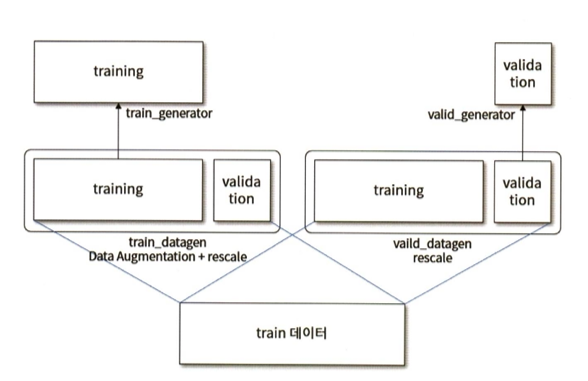

In [ ]:
Image('/content/drive/MyDrive/edu.kenshi/2021/품질재단/DL/new_res/전이학습-이미지부풀리기.png')

# 훈련 및 검증용 데이터 준비

In [ ]:
'''
  - train_generator에서 데이터 획득 (batch_size 만큼)
  - 이를 이용하여서 전이학습으로 hub에서 제공받은 모델(feature_model)에 입력
  - 예측값이 나온다
  - 예측값은 X, 실제 정답을 y로 구성하여서 데이터 준비
'''
# 훈련용 전체 데이터를 풀로 3회 진행(epoch)
(7718*3) // batch_size, (7718) // batch_size, ((7718) // batch_size)*3
steps = (7718*2) // batch_size
train_X = []
train_Y = []

for idx in range( steps ):
  if idx % 100 ==0 : print( idx )
  # 제너레이터에서 x,y 추출 -> 이미지 부풀리가 진행
  x, y = train_generator.next()
  # 전이학습용으로 로드한 모델을 이용하여 예측 수행
  # 기존 모델의 특징값을 이용하여 예측 수행
  y_   = feature_model.predict( x )
  # 예측값추가
  train_X.extend( y_ )
  # 정답 추가
  train_Y.extend( y )
  pass

print( idx )
# 예측값, 정답을 x,y라는 형태로 모아 둔다
train_X = np.array( train_X )
train_Y = np.array( train_Y )

train_X.shape, train_Y.shape

0
100
200
300
400
481


((15398, 2048), (15398, 120))

In [ ]:
# 검증용 데이터 준비
valid_X = []
valid_Y = []

for idx in range( vaild_generator.n ):
  x, y = vaild_generator.next()
  # 기존 모델의 특징값을 이용하여 예측 수행
  y_   = feature_model.predict( x )
  valid_X.extend( y_ )
  valid_Y.extend( y )
  pass

valid_X = np.array( valid_X )
valid_Y = np.array( valid_Y )

valid_X.shape, valid_Y.shape

((2504, 2048), (2504, 120))

# 신경망 구성

  - 심플하게 구성

In [ ]:
# 모델 생성
# 입력 shape (2048, )
# 중간층 shape (512,)
# 과적합방지 shape (512,)
# 출력 shape (120)
# ANN 수준
model = tf.keras.Sequential([
  # Inception V3를 받은 층 -> shape을 줄인다
  tf.keras.layers.Dense( 512, activation='relu', input_shape=(2048,) ),
  # 과적합 방지
  tf.keras.layers.Dropout(0.5),  
  # 출력층 수렴
  tf.keras.layers.Dense( 120, activation='softmax' )

])

# 컴파일
model.compile( tf.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy']  )
# 요약 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               61560     
Total params: 1,110,648
Trainable params: 1,110,648
Non-trainable params: 0
_________________________________________________________________


# 학습 성과 확인

Epoch 1/10
482/482 [==============================] - 7s 14ms/step - loss: 2.7175 - accuracy: 0.4843 - val_loss: 0.8163 - val_accuracy: 0.8702
Epoch 2/10
482/482 [==============================] - 6s 13ms/step - loss: 0.8160 - accuracy: 0.8048 - val_loss: 0.4081 - val_accuracy: 0.8890
Epoch 3/10
482/482 [==============================] - 7s 14ms/step - loss: 0.5512 - accuracy: 0.8419 - val_loss: 0.3436 - val_accuracy: 0.8970
Epoch 4/10
482/482 [==============================] - 6s 13ms/step - loss: 0.4604 - accuracy: 0.8602 - val_loss: 0.3236 - val_accuracy: 0.8962
Epoch 5/10
482/482 [==============================] - 6s 13ms/step - loss: 0.4061 - accuracy: 0.8752 - val_loss: 0.3128 - val_accuracy: 0.8942
Epoch 6/10
482/482 [==============================] - 6s 13ms/step - loss: 0.3632 - accuracy: 0.8871 - val_loss: 0.3098 - val_accuracy: 0.9006
Epoch 7/10
482/482 [==============================] - 6s 13ms/step - loss: 0.3352 - accuracy: 0.8926 - val_loss: 0.3064 - val_accuracy: 0.8986

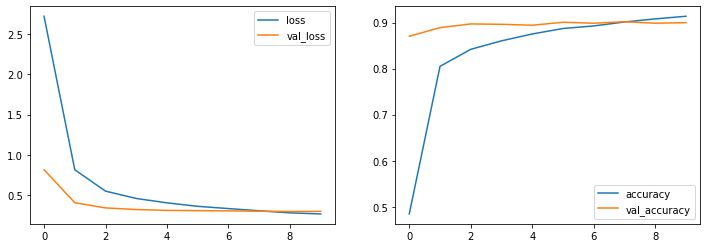

In [ ]:
# 학습 
hist = model.fit( train_X, train_Y, epochs=10, validation_data=(valid_X, valid_Y), batch_size=32 )

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot( 1, 2, 1)
plt.plot( hist.history['loss'], label='loss' )
plt.plot( hist.history['val_loss'], label='val_loss' )

plt.legend()

plt.subplot( 1, 2, 2)
plt.plot( hist.history['accuracy'], label='accuracy' )
plt.plot( hist.history['val_accuracy'] , label='val_accuracy')

plt.legend()

plt.show()
# 결과라 아주 좋게 나왔다